<h2> DQN Agent <h2>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define drift and diffusion functions
def mu(x, coupling_constants):
    return -0.5 * x + coupling_constants[0] * x

def sigma(x, coupling_constants):
    return 0.1 * (1 + coupling_constants[1])  # Ensure non-negative diffusion

class Time_Series_Generator:
    def __init__(self, num_nodes, coupling_constants, correlation_matrix):
        self.num_nodes = num_nodes
        self.coupling_constants = coupling_constants
        self.correlation_matrix = correlation_matrix
        self.correlation_decomposition = np.linalg.cholesky(correlation_matrix)  # Cholesky decomposition
        self.time_series = None

    def simulate_sde(self, mu, sigma, dt, num_steps):
        self.time_series = np.full((self.num_nodes, num_steps), 10.0)  # Initialize time series

        for t in range(1, num_steps):
            dW = np.random.normal(size=self.num_nodes) * np.sqrt(dt)
            correlated_noise = np.dot(self.correlation_decomposition, dW)

            drift = mu(self.time_series[:, t-1], self.coupling_constants) * dt
            diffusion = sigma(self.time_series[:, t-1], self.coupling_constants) * correlated_noise

            # Avoid overflow by capping drift and diffusion at smaller values
            drift = np.clip(drift, -5, 5)
            diffusion = np.clip(diffusion, -5, 5)

            # Additive update to avoid exponential growth and overflow
            self.time_series[:, t] = self.time_series[:, t-1] + drift + diffusion

            # Ensure the time series doesn't grow too large or become NaN
            self.time_series[:, t] = np.clip(self.time_series[:, t], -100, 100)

            # Check for any NaN values in time series (result from overflow)
            if np.any(np.isnan(self.time_series[:, t])):
                raise ValueError("NaN values encountered during simulation. Adjust the clipping or step size.")

    def get_correlation_matrix(self):
        if self.time_series is None:
            raise ValueError("Time series has not been simulated yet.")
        return np.corrcoef(self.time_series)

# Define parameter ranges for grid search
def create_grid(start, end, step):
    return np.arange(start, end + step, step)

def grid_search(num_nodes, target_correlation_matrix, dt, num_steps, parameter_ranges):
    best_error = float('inf')
    best_params = None

    # Create a grid of parameter combinations
    grids = [create_grid(start, end, step) for start, end, step in parameter_ranges]

    for coupling1 in grids[0]:
        for coupling2 in grids[1]:
            # Define coupling constants for the current grid point
            coupling_constants = np.array([coupling1, coupling2])

            # Create and simulate generator
            generator = Time_Series_Generator(num_nodes, coupling_constants, target_correlation_matrix)
            generator.simulate_sde(mu, sigma, dt, num_steps)
            simulated_correlation_matrix = generator.get_correlation_matrix()

            # Compute the error
            error = np.sum((simulated_correlation_matrix - target_correlation_matrix) ** 2)

            # Update the best parameters if the current error is lower
            if error < best_error:
                best_error = error
                best_params = coupling_constants

    return best_params, best_error

In [2]:
# Example usage
num_nodes = 5

# High correlation
target_correlation_matrix = np.array([
    [1.0, 0.9, 0.90, 0.8, 0.75],
    [0.9, 1.0, 0.88, 0.82, 0.78],
    [0.85, 0.88, 1.0, 0.86, 0.8],
    [0.8, 0.82, 0.86, 1.0, 0.85],
    [0.75, 0.78, 0.8, 0.85, 1.0]
])

dt = 0.01
num_steps = 1000

# Define parameter ranges for coupling constants
parameter_ranges = [(0.0, 1.0, 0.1), (0.0, 1.0, 0.1)]  # (start, end, step) for each constant

# Perform grid search
best_params, best_error = grid_search(num_nodes, target_correlation_matrix, dt, num_steps, parameter_ranges)

# Simulate with best parameters
t_series = Time_Series_Generator(num_nodes, best_params, target_correlation_matrix)
t_series.simulate_sde(mu, sigma, dt, num_steps)

In [3]:
print("Best coupling constants:", best_params)
print("Best error:", best_error)

Best coupling constants: [0.5 0.8]
Best error: 0.04695539742496588


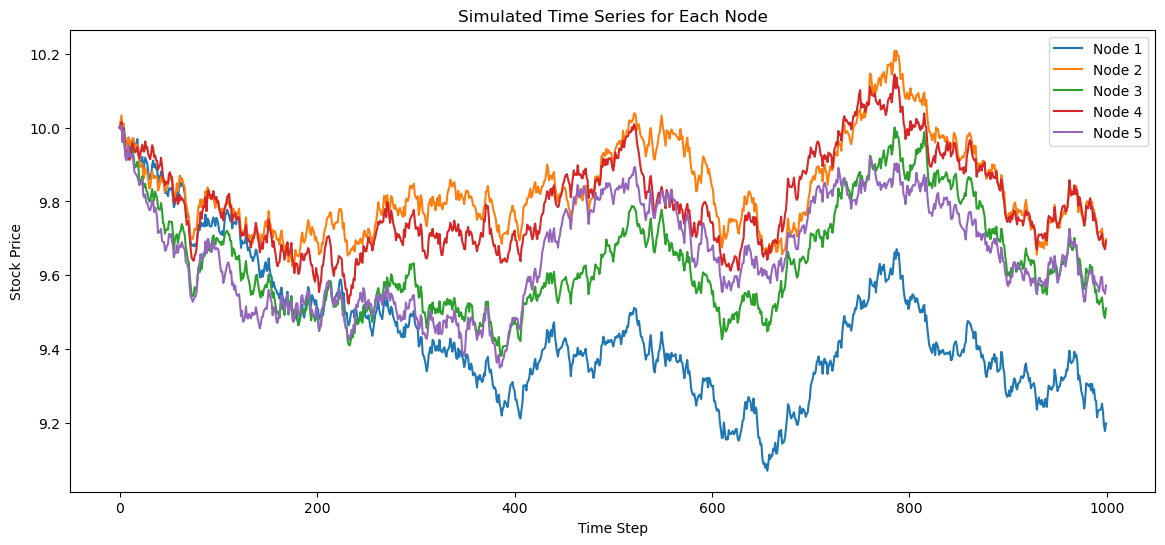

In [4]:
# Plotting the time series
plt.figure(figsize=(14, 6))
for i in range(num_nodes):
    plt.plot(t_series.time_series[i, :], label=f'Node {i+1}')
plt.title('Simulated Time Series for Each Node')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

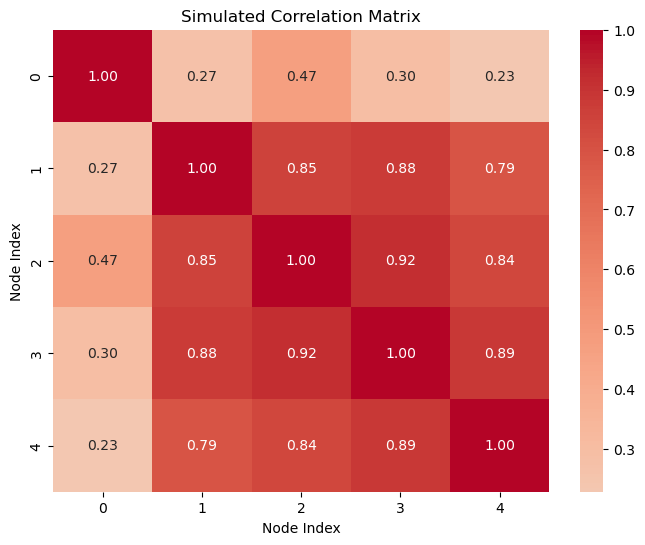

In [5]:
# Plotting the correlation matrix
simulated_correlation_matrix = t_series.get_correlation_matrix()
plt.figure(figsize=(8, 6))
sns.heatmap(simulated_correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Simulated Correlation Matrix')
plt.xlabel('Node Index')
plt.ylabel('Node Index')
plt.show()

In [6]:
#Time series of a single node rescaled to match a stock-price

import pandas as pd

# Convert one of the nodes' time series to stock prices
node_index = 2  # Choose the node index to use
price_series = t_series.time_series[node_index]

# Normalize the stock prices to a realistic range
min_price, max_price = 50, 150
normalized_prices = np.interp(price_series, (price_series.min(), price_series.max()), (min_price, max_price))

# Create a date range
dates = pd.date_range(start='2023-01-01', periods=num_steps, freq='D')
df = pd.DataFrame(data={'Date': dates, 'StockPrice': normalized_prices})

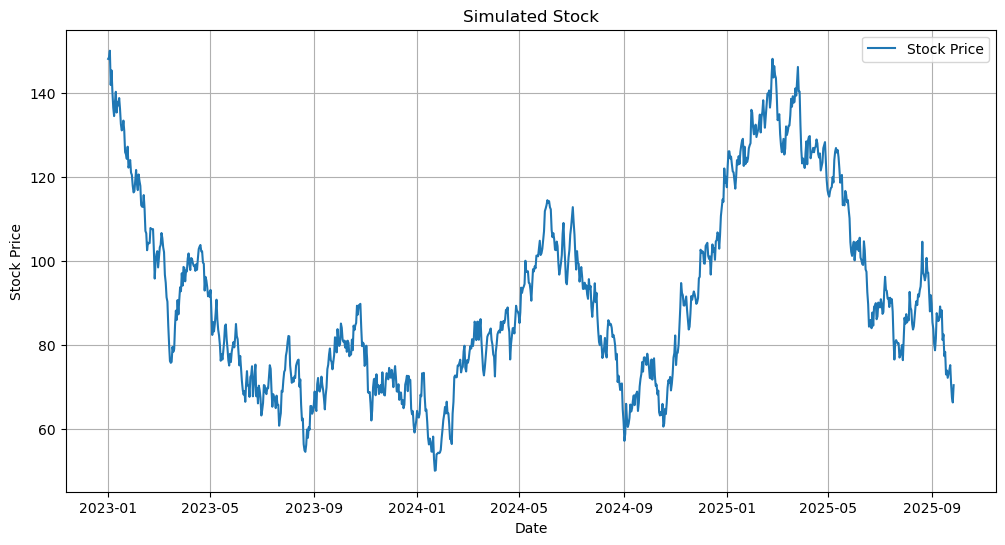

In [7]:
# Plot the stock prices
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['StockPrice'], label='Stock Price')
plt.title('Simulated Stock')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

In [14]:
import numpy as np
import random
from collections import deque
import pickle
from keras.models import Sequential
from keras.layers import Dense

class StockTradingEnvironment:
    def __init__(self, stock_prices, transaction_fee=0.001):
        self.stock_prices = stock_prices
        self.transaction_fee = transaction_fee
        self.reset()

    def reset(self):
        self.current_step = 0
        self.balance = 1000
        self.shares = 0
        self.buy_price = 0  # Track the last buy price
        print(f"Environment reset. Initial balance: {self.balance}, Shares: {self.shares}")
        return self.get_state()

    def get_state(self, window_size=5):
        start = max(0, self.current_step - window_size + 1)
        state = self.stock_prices[start:self.current_step + 1]
        state = np.pad(state, (window_size - len(state), 0), 'constant')
        return state

    def take_action(self, action):
        current_price = self.stock_prices[self.current_step]
        reward = 0
        action_str = ""
        
        if action == 0:  # Hold
            reward = 0.1 if self.current_step > 0 and current_price > self.stock_prices[self.current_step - 1] else -0.01
            action_str = "Hold"

        elif action == 1:  # Buy
            if self.balance >= current_price:
                self.shares += 1
                self.balance -= current_price * (1 + self.transaction_fee)
                self.buy_price = current_price  # Update the buy price
                reward = -0.05
                action_str = "Buy"
            else:
                reward = -1  # Penalty for insufficient balance
                action_str = "Buy (Failed)"
        
        elif action == 2:  # Sell
            if self.shares > 0:
                sale_amount = current_price * (1 - self.transaction_fee)
                profit = (current_price - self.buy_price) * self.shares  # Profit from the sale
                self.balance += sale_amount
                self.shares -= 1
                reward = profit + 0.1  # Reward includes profit and a small bonus
                action_str = "Sell"
            else:
                reward = -1  # Penalty for trying to sell with no shares
                action_str = "Sell (Failed)"

        # Move to the next step
        self.current_step += 1
        done = self.current_step >= len(self.stock_prices) - 1

        print(f"Step: {self.current_step}, Action: {action_str}, "
              f"Price: {current_price:.2f}, Balance: {self.balance:.2f}, "
              f"Shares: {self.shares}, Reward: {reward:.2f}")
        
        return self.get_state(), reward, done


import pickle
import numpy as np
import random
from collections import deque
from keras.models import Sequential
from keras.layers import Dense

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # Discount rate
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer='adam')
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        q_values = self.model.predict(np.reshape(state, [1, self.state_size]))
        return np.argmax(q_values[0])

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return

        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward if done else reward + self.gamma * np.amax(self.model.predict(np.reshape(next_state, [1, self.state_size]))[0])
            target_f = self.model.predict(np.reshape(state, [1, self.state_size]))
            target_f[0][action] = target
            self.model.fit(np.reshape(state, [1, self.state_size]), target_f, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def save_model(self, name):
        self.model.save_weights(name)

    def load_model(self, name):
        self.model.load_weights(name)

    def save_q_values(self, states, filename):
        q_values_dict = {}
        for state in states:
            state_reshaped = np.reshape(state, [1, self.state_size])
            q_values = self.model.predict(state_reshaped)[0]
            q_values_dict[str(state.tolist())] = q_values.tolist()

        # Save Q-values dictionary to a file
        with open(filename, 'wb') as f:
            pickle.dump(q_values_dict, f)


class StockTradingAgent:
    def __init__(self, stock_prices):
        self.env = StockTradingEnvironment(stock_prices)
        self.state_size = 5  # Window size for state representation
        self.action_size = 3  # Actions: Hold, Buy, Sell
        self.agent = DQNAgent(self.state_size, self.action_size)

    def train(self, epochs, batch_size=32):
        for e in range(epochs):
            state = self.env.reset()
            state = np.reshape(state, [1, self.state_size])

            for time in range(len(self.env.stock_prices) - 1):
                action = self.agent.choose_action(state)
                next_state, reward, done = self.env.take_action(action)
                next_state = np.reshape(next_state, [1, self.state_size])
                self.agent.remember(state, action, reward, next_state, done)

                state = next_state

                if done:
                    total_value = self.env.balance + self.env.shares * self.env.stock_prices[self.env.current_step]
                    print(f"Episode: {e + 1}/{epochs}, Total Value: {total_value:.2f}, Epsilon: {self.agent.epsilon:.2f}")
                    break

                self.agent.replay(batch_size)

    def save_q_values(self, filename):
        # Collect all states encountered during training
        all_states = [self.env.get_state() for _ in range(len(self.env.stock_prices))]
        self.agent.save_q_values(all_states, filename)

In [15]:
# Initialize and train the multi-agent trading bot with an initial balance of $100,000 per agent
agent = StockTradingAgent(df['StockPrice'])
agent.train(epochs=1, batch_size=32)
# Save the model after training
agent.agent.save_model("dqn_agent.h5")

Environment reset. Initial balance: 1000, Shares: 0
Environment reset. Initial balance: 1000, Shares: 0
Step: 1, Action: Hold, Price: 148.05, Balance: 1000.00, Shares: 0, Reward: -0.01
Step: 2, Action: Sell (Failed), Price: 148.43, Balance: 1000.00, Shares: 0, Reward: -1.00
Step: 3, Action: Hold, Price: 150.00, Balance: 1000.00, Shares: 0, Reward: 0.10
Step: 4, Action: Buy, Price: 141.84, Balance: 858.02, Shares: 1, Reward: -0.05
Step: 5, Action: Hold, Price: 145.31, Balance: 858.02, Shares: 1, Reward: 0.10
Step: 6, Action: Sell, Price: 140.25, Balance: 998.12, Shares: 0, Reward: -1.50
Step: 7, Action: Buy, Price: 136.42, Balance: 861.56, Shares: 1, Reward: -0.05
Step: 8, Action: Hold, Price: 134.44, Balance: 861.56, Shares: 1, Reward: -0.01
Step: 9, Action: Hold, Price: 137.72, Balance: 861.56, Shares: 1, Reward: 0.10
Step: 10, Action: Buy, Price: 140.22, Balance: 721.20, Shares: 2, Reward: -0.05
Step: 11, Action: Hold, Price: 135.29, Balance: 721.20, Shares: 2, Reward: -0.01
Step: 12

Step: 101, Action: Buy, Price: 99.49, Balance: 869.51, Shares: 1, Reward: -0.05
Step: 102, Action: Hold, Price: 98.80, Balance: 869.51, Shares: 1, Reward: -0.01
Step: 103, Action: Sell, Price: 98.86, Balance: 968.28, Shares: 0, Reward: -0.53
Step: 104, Action: Buy, Price: 97.59, Balance: 870.59, Shares: 1, Reward: -0.05
Step: 105, Action: Sell, Price: 99.15, Balance: 969.63, Shares: 0, Reward: 1.65
Step: 106, Action: Sell (Failed), Price: 97.85, Balance: 969.63, Shares: 0, Reward: -1.00
Step: 107, Action: Buy, Price: 100.54, Balance: 868.99, Shares: 1, Reward: -0.05
Step: 108, Action: Sell, Price: 102.78, Balance: 971.67, Shares: 0, Reward: 2.34
Step: 109, Action: Sell (Failed), Price: 103.36, Balance: 971.67, Shares: 0, Reward: -1.00
Step: 110, Action: Buy, Price: 103.75, Balance: 867.81, Shares: 1, Reward: -0.05
Step: 111, Action: Sell, Price: 102.21, Balance: 969.93, Shares: 0, Reward: -1.43
Step: 112, Action: Sell (Failed), Price: 102.24, Balance: 969.93, Shares: 0, Reward: -1.00
S

Step: 203, Action: Sell (Failed), Price: 60.72, Balance: 915.81, Shares: 0, Reward: -1.00
Step: 204, Action: Sell (Failed), Price: 62.37, Balance: 915.81, Shares: 0, Reward: -1.00
Step: 205, Action: Sell (Failed), Price: 63.71, Balance: 915.81, Shares: 0, Reward: -1.00
Step: 206, Action: Sell (Failed), Price: 69.04, Balance: 915.81, Shares: 0, Reward: -1.00
Step: 207, Action: Buy, Price: 68.77, Balance: 846.97, Shares: 1, Reward: -0.05
Step: 208, Action: Sell, Price: 71.53, Balance: 918.43, Shares: 0, Reward: 2.86
Step: 209, Action: Hold, Price: 73.54, Balance: 918.43, Shares: 0, Reward: 0.10
Step: 210, Action: Hold, Price: 73.99, Balance: 918.43, Shares: 0, Reward: 0.10
Step: 211, Action: Sell (Failed), Price: 77.37, Balance: 918.43, Shares: 0, Reward: -1.00
Step: 212, Action: Hold, Price: 78.47, Balance: 918.43, Shares: 0, Reward: 0.10
Step: 213, Action: Sell (Failed), Price: 80.62, Balance: 918.43, Shares: 0, Reward: -1.00
Step: 214, Action: Sell (Failed), Price: 82.08, Balance: 918

Step: 301, Action: Buy, Price: 79.66, Balance: 845.18, Shares: 1, Reward: -0.05
Step: 302, Action: Sell, Price: 80.50, Balance: 925.60, Shares: 0, Reward: 0.94
Step: 303, Action: Hold, Price: 80.22, Balance: 925.60, Shares: 0, Reward: -0.01
Step: 304, Action: Hold, Price: 74.95, Balance: 925.60, Shares: 0, Reward: -0.01
Step: 305, Action: Buy, Price: 75.52, Balance: 850.00, Shares: 1, Reward: -0.05
Step: 306, Action: Sell, Price: 79.76, Balance: 929.69, Shares: 0, Reward: 4.34
Step: 307, Action: Sell (Failed), Price: 76.57, Balance: 929.69, Shares: 0, Reward: -1.00
Step: 308, Action: Hold, Price: 68.67, Balance: 929.69, Shares: 0, Reward: -0.01
Step: 309, Action: Hold, Price: 68.54, Balance: 929.69, Shares: 0, Reward: -0.01
Step: 310, Action: Hold, Price: 68.74, Balance: 929.69, Shares: 0, Reward: 0.10
Step: 311, Action: Hold, Price: 65.96, Balance: 929.69, Shares: 0, Reward: -0.01
Step: 312, Action: Sell (Failed), Price: 61.96, Balance: 929.69, Shares: 0, Reward: -1.00
Step: 313, Acti

Step: 400, Action: Hold, Price: 63.64, Balance: 915.60, Shares: 0, Reward: -0.01
Step: 401, Action: Hold, Price: 66.43, Balance: 915.60, Shares: 0, Reward: 0.10
Step: 402, Action: Sell (Failed), Price: 63.71, Balance: 915.60, Shares: 0, Reward: -1.00
Step: 403, Action: Sell (Failed), Price: 63.64, Balance: 915.60, Shares: 0, Reward: -1.00
Step: 404, Action: Hold, Price: 61.05, Balance: 915.60, Shares: 0, Reward: -0.01
Step: 405, Action: Hold, Price: 57.51, Balance: 915.60, Shares: 0, Reward: -0.01
Step: 406, Action: Buy, Price: 57.51, Balance: 858.04, Shares: 1, Reward: -0.05
Step: 407, Action: Buy, Price: 56.36, Balance: 801.62, Shares: 2, Reward: -0.05
Step: 408, Action: Sell, Price: 63.60, Balance: 865.16, Shares: 1, Reward: 14.58
Step: 409, Action: Sell, Price: 66.40, Balance: 931.49, Shares: 0, Reward: 10.15
Step: 410, Action: Sell (Failed), Price: 72.32, Balance: 931.49, Shares: 0, Reward: -1.00
Step: 411, Action: Sell (Failed), Price: 72.69, Balance: 931.49, Shares: 0, Reward: -

Step: 498, Action: Buy, Price: 94.74, Balance: 671.51, Shares: 3, Reward: -0.05
Step: 499, Action: Buy, Price: 94.60, Balance: 576.81, Shares: 4, Reward: -0.05
Step: 500, Action: Sell, Price: 93.05, Balance: 669.77, Shares: 3, Reward: -6.09
Step: 501, Action: Buy, Price: 90.48, Balance: 579.20, Shares: 4, Reward: -0.05
Step: 502, Action: Hold, Price: 94.28, Balance: 579.20, Shares: 4, Reward: 0.10
Step: 503, Action: Sell, Price: 97.98, Balance: 677.09, Shares: 3, Reward: 30.10
Step: 504, Action: Hold, Price: 97.45, Balance: 677.09, Shares: 3, Reward: -0.01
Step: 505, Action: Sell, Price: 98.67, Balance: 775.66, Shares: 2, Reward: 24.67
Step: 506, Action: Sell, Price: 98.21, Balance: 873.77, Shares: 1, Reward: 15.55
Step: 507, Action: Sell, Price: 101.22, Balance: 974.88, Shares: 0, Reward: 10.84
Step: 508, Action: Sell (Failed), Price: 101.20, Balance: 974.88, Shares: 0, Reward: -1.00
Step: 509, Action: Buy, Price: 101.06, Balance: 873.73, Shares: 1, Reward: -0.05
Step: 510, Action: Se

Step: 598, Action: Buy, Price: 82.35, Balance: 912.25, Shares: 1, Reward: -0.05
Step: 599, Action: Sell, Price: 81.47, Balance: 993.64, Shares: 0, Reward: -0.78
Step: 600, Action: Sell (Failed), Price: 79.87, Balance: 993.64, Shares: 0, Reward: -1.00
Step: 601, Action: Buy, Price: 76.46, Balance: 917.10, Shares: 1, Reward: -0.05
Step: 602, Action: Sell, Price: 77.83, Balance: 994.85, Shares: 0, Reward: 1.47
Step: 603, Action: Hold, Price: 71.12, Balance: 994.85, Shares: 0, Reward: -0.01
Step: 604, Action: Hold, Price: 72.62, Balance: 994.85, Shares: 0, Reward: 0.10
Step: 605, Action: Buy, Price: 71.02, Balance: 923.75, Shares: 1, Reward: -0.05
Step: 606, Action: Buy, Price: 69.23, Balance: 854.46, Shares: 2, Reward: -0.05
Step: 607, Action: Hold, Price: 70.58, Balance: 854.46, Shares: 2, Reward: 0.10
Step: 608, Action: Buy, Price: 70.78, Balance: 783.60, Shares: 3, Reward: -0.05
Step: 609, Action: Sell, Price: 64.62, Balance: 848.16, Shares: 2, Reward: -18.39
Step: 610, Action: Buy, Pr

Step: 696, Action: Hold, Price: 89.73, Balance: 1022.03, Shares: 0, Reward: -0.01
Step: 697, Action: Hold, Price: 90.13, Balance: 1022.03, Shares: 0, Reward: 0.10
Step: 698, Action: Hold, Price: 91.11, Balance: 1022.03, Shares: 0, Reward: 0.10
Step: 699, Action: Sell (Failed), Price: 95.82, Balance: 1022.03, Shares: 0, Reward: -1.00
Step: 700, Action: Hold, Price: 96.17, Balance: 1022.03, Shares: 0, Reward: 0.10
Step: 701, Action: Sell (Failed), Price: 102.62, Balance: 1022.03, Shares: 0, Reward: -1.00
Step: 702, Action: Sell (Failed), Price: 101.82, Balance: 1022.03, Shares: 0, Reward: -1.00
Step: 703, Action: Sell (Failed), Price: 102.28, Balance: 1022.03, Shares: 0, Reward: -1.00
Step: 704, Action: Hold, Price: 102.08, Balance: 1022.03, Shares: 0, Reward: -0.01
Step: 705, Action: Hold, Price: 99.36, Balance: 1022.03, Shares: 0, Reward: -0.01
Step: 706, Action: Sell (Failed), Price: 99.29, Balance: 1022.03, Shares: 0, Reward: -1.00
Step: 707, Action: Sell (Failed), Price: 103.53, Bal

Step: 793, Action: Buy, Price: 134.03, Balance: 949.84, Shares: 1, Reward: -0.05
Step: 794, Action: Buy, Price: 134.87, Balance: 814.83, Shares: 2, Reward: -0.05
Step: 795, Action: Hold, Price: 130.13, Balance: 814.83, Shares: 2, Reward: -0.01
Step: 796, Action: Buy, Price: 127.48, Balance: 687.22, Shares: 3, Reward: -0.05
Step: 797, Action: Buy, Price: 125.83, Balance: 561.26, Shares: 4, Reward: -0.05
Step: 798, Action: Buy, Price: 127.39, Balance: 433.75, Shares: 5, Reward: -0.05
Step: 799, Action: Sell, Price: 129.01, Balance: 562.63, Shares: 4, Reward: 8.22
Step: 800, Action: Sell, Price: 125.28, Balance: 687.79, Shares: 3, Reward: -8.31
Step: 801, Action: Sell, Price: 126.70, Balance: 814.36, Shares: 2, Reward: -1.96
Step: 802, Action: Buy, Price: 131.97, Balance: 682.25, Shares: 3, Reward: -0.05
Step: 803, Action: Buy, Price: 129.94, Balance: 552.18, Shares: 4, Reward: -0.05
Step: 804, Action: Buy, Price: 130.77, Balance: 421.29, Shares: 5, Reward: -0.05
Step: 805, Action: Buy, P

Step: 892, Action: Hold, Price: 99.21, Balance: 877.25, Shares: 2, Reward: -0.01
Step: 893, Action: Hold, Price: 98.99, Balance: 877.25, Shares: 2, Reward: -0.01
Step: 894, Action: Sell, Price: 104.62, Balance: 981.77, Shares: 1, Reward: 9.07
Step: 895, Action: Sell, Price: 102.45, Balance: 1084.11, Shares: 0, Reward: 2.41
Step: 896, Action: Hold, Price: 97.92, Balance: 1084.11, Shares: 0, Reward: -0.01
Step: 897, Action: Hold, Price: 97.37, Balance: 1084.11, Shares: 0, Reward: -0.01
Step: 898, Action: Hold, Price: 92.51, Balance: 1084.11, Shares: 0, Reward: -0.01
Step: 899, Action: Hold, Price: 89.65, Balance: 1084.11, Shares: 0, Reward: -0.01
Step: 900, Action: Hold, Price: 84.31, Balance: 1084.11, Shares: 0, Reward: -0.01
Step: 901, Action: Buy, Price: 85.26, Balance: 998.77, Shares: 1, Reward: -0.05
Step: 902, Action: Sell, Price: 85.90, Balance: 1084.58, Shares: 0, Reward: 0.74
Step: 903, Action: Sell (Failed), Price: 83.93, Balance: 1084.58, Shares: 0, Reward: -1.00
Step: 904, Ac

Step: 990, Action: Buy, Price: 78.30, Balance: 891.85, Shares: 3, Reward: -0.05
Step: 991, Action: Buy, Price: 72.92, Balance: 818.85, Shares: 4, Reward: -0.05
Step: 992, Action: Buy, Price: 73.89, Balance: 744.89, Shares: 5, Reward: -0.05
Step: 993, Action: Hold, Price: 72.13, Balance: 744.89, Shares: 5, Reward: -0.01
Step: 994, Action: Hold, Price: 73.07, Balance: 744.89, Shares: 5, Reward: 0.10
Step: 995, Action: Sell, Price: 74.00, Balance: 818.82, Shares: 4, Reward: 0.68
Step: 996, Action: Sell, Price: 75.14, Balance: 893.88, Shares: 3, Reward: 5.11
Step: 997, Action: Buy, Price: 70.67, Balance: 823.14, Shares: 4, Reward: -0.05
Step: 998, Action: Hold, Price: 67.45, Balance: 823.14, Shares: 4, Reward: -0.01
Step: 999, Action: Buy, Price: 66.26, Balance: 756.82, Shares: 5, Reward: -0.05
Episode: 1/1, Total Value: 1108.66, Epsilon: 0.01


In [16]:
agent.save_q_values(filename="dqn_qvalues.npy")

In [19]:
import numpy as np

# Load the trained agent
  # Load the pre-trained model weights

# New stock price data for testing (example data)
new_stock_prices = np.array([100, 101, 102, 103, 102, 101, 104, 105, 106])  # Replace with your test stock prices
agent = StockTradingAgent(stock_prices=new_stock_prices)  # Initialize agent without stock prices for loading model
agent.agent.load_model("dqn_agent.h5")

# Initialize the environment with new stock prices
test_env = StockTradingEnvironment(new_stock_prices, transaction_fee=0.001)

# Reset the environment to get the initial state
state = test_env.reset()
state = np.reshape(state, [1, agent.state_size])  # Reshape to match the input format for the model

# Simulate the trading environment using the loaded model
done = False
while not done:
    action = agent.agent.choose_action(state)  # Use the agent to choose the next action
    next_state, reward, done = test_env.take_action(action)  # Take action and observe the outcome
    next_state = np.reshape(next_state, [1, agent.state_size])  # Reshape the next state for the model input
    state = next_state  # Update the state for the next step

# After the loop, print the final trading results
total_value = test_env.balance + test_env.shares * test_env.stock_prices[test_env.current_step]
print(f"Final Total Value: {total_value:.2f}, Final Balance: {test_env.balance:.2f}, Final Shares: {test_env.shares}")

Environment reset. Initial balance: 1000, Shares: 0
Environment reset. Initial balance: 1000, Shares: 0
Environment reset. Initial balance: 1000, Shares: 0
Step: 1, Action: Hold, Price: 100.00, Balance: 1000.00, Shares: 0, Reward: -0.01
Step: 2, Action: Buy, Price: 101.00, Balance: 898.90, Shares: 1, Reward: -0.05
Step: 3, Action: Sell, Price: 102.00, Balance: 1000.80, Shares: 0, Reward: 1.10
Step: 4, Action: Buy, Price: 103.00, Balance: 897.69, Shares: 1, Reward: -0.05
Step: 5, Action: Buy, Price: 102.00, Balance: 795.59, Shares: 2, Reward: -0.05
Step: 6, Action: Buy, Price: 101.00, Balance: 694.49, Shares: 3, Reward: -0.05
Step: 7, Action: Hold, Price: 104.00, Balance: 694.49, Shares: 3, Reward: 0.10
Step: 8, Action: Hold, Price: 105.00, Balance: 694.49, Shares: 3, Reward: 0.10
Final Total Value: 1012.49, Final Balance: 694.49, Final Shares: 3
